# Introduction to Data Science

# The CRISP-DM approach to Data Science Tasks

_________________________

# Business Understanding

                    
### The Business Understanding phase focuses on understanding the objectives and requirements of the project.  
+ Determine business objectives:  

O objetivo do nosso projeto é entender quais são os fatores que influenciam os jovens e a educação brasileira. Utilizando os dados do INEP (Instituto Nacional de Estudos e Pesquisas Educacionais), podemos coletar o município, uf, média de alunos por turma, a taxa de reprovação, a taxa de abandono, a situação socio-econômica e diversas outras informações sobre o Ensino Médio de milhares de escolas ao redor do país e usar isso pra nos ajudar a compreender o que está por trás de uma educação de sucesso (ou não).

+ Assess situation:  

A educação brasileira é extremamente heterogênea, contando desde escolas de elite, com atividades complementares e baixa quantidade de aluno por professor, até escolas públicas cujo corpo docente nem sempre possui a formação acadêmica necessária pra matéria que dá aula. Os dados para pesquisas desse nível são extremamente extensos e de fácil acesso, porém de fonte única (INEP), vez que são coletados pelo governo e disponibilizados para a população de forma gratuita e transparente.

+ Determine data mining goals: 

Coletar os dados sobre as escolas do ensino médio brasileiro, pra saber se elas são públicas ou privadas, urbanas ou rurais, medidas que comprovem  o engajamento do corpo discente com a educação (taxa de abandono, de reprovação) e a qualificação do corpo doscente. Todos esses dados são disponibilizados pelo INEP.

+ Produce project plan:  
    + Coletar os Indicadores Educacionais do INEP.

    + Entender os dados, explorá-los e descrevê-los. 

    + Verificar quais são as tabelas e colunas relevantes para os objetivos e se desfazer do restante.

    + Filtrar os dados, selecionando apenas escolas do ensino médio.

    + Observar a correlação entre as variáveis e a taxa de abandono/taxa de reprovação.

    + Construir um modelo que preveja a taxa de abandono e reprovação de uma escola, baseando-se nos outros dados obtidos.

    + Separar os nossos dados em treino e teste, utilizando o treino para treinar o modelo e o teste para avaliar as previsões.

    + Fazer o relatório final e revisar o projeto.



In [24]:
# aquisição dos dados
import basedosdados as bd
import requests
from bs4 import BeautifulSoup as bs
import numpy as np

# visualização
from matplotlib import pyplot as plt
import seaborn as sns

# manipulação
import pandas as pd
import pickle
from sklearn import preprocessing

# Data Understanding  

+ Collect initial data:  
+ Describe data:  
+ Explore data:  
+ Verify data quality:  

## Collect initial data:  

In [2]:
# Define algumas variáveis úteis
dataset_id = "br_inep_indicadores_educacionais"
billing_project_id="trabalho-amd"

Download das tabelas do dataset:
(o código comentado baixa do site os .csv)

In [3]:
#bd.download(dataset_id=dataset_id, table_id='escola', savepath='data/escola.csv', billing_project_id=billing_project_id)
df_escola = pd.read_csv('data/escola.csv')

In [4]:
# carrega o dataset com os dados já tratados
# executando esse chunk é possível pular direto para a sessão 3
# df_escola_em = pd.read_csv('df_escola_em.csv')

Como pode ser justificado na sessão *Describe Data*, o dataset `escola.csv` tem apenas a coluna `id_municipio`, porém nenhum identificador de qual município é aquele nem qual a sua UF. <br>
O IBGE classifica cada município com um código de 7 dígitos onde os dois primeiros representam a UF (referência: <https://www.ibge.gov.br/explica/codigos-dos-municipios.php>). <br>
Como queremos analisar os dados por UF também, realizamos o scrapping dos códigos das UF presentes no link acima, mais para fins de aprendizado do que por questões práticas já que se tratavam de poucos dados.

In [7]:
html = requests.get("https://www.ibge.gov.br/explica/codigos-dos-municipios.php")
soup = bs(html.text)

# seleciona a tag table
table = soup.find('table')

# extrai o nome das colunas da tabela
column_names = []
for name in table.find('tr'):
    if name != "\n":
        column_names.append(name.text)

# extrai as linhas da tabela
trows = soup.find('tbody').find_all('tr')
tcols = []

# itera sobre as linhas
for tr in trows:
    # cria uma lista das colunas dessa linha
    col = tr.find_all('td')
    uf = col[0].text
    code = int(col[1].text.replace('ver municípios', ''))
    tcols.append([uf, code])

df_codigos_uf = pd.DataFrame(tcols, columns = column_names)
df_codigos_uf.head()

,UFs,Códigos
0,Acre,12
1,Alagoas,27
2,Amapá,16
3,Amazonas,13
4,Bahia,29


## Describe Data

Começando pela tabela `escola` que é a mais importante do dataset, podemos ver que ela é formada por 208 colunas, destas 205 numéricas e 3 categóricas.

Algumas colunas notáveis são:
+ **rede:** 

municipal, estadual, federal ou privada;

+ **localização:**

urbana ou rural;

+ **atu**: Média de Alunos por Turma:

Quociente entre a matrícula total e o total de turmas da escola;

+ **had**: Média de Horas-Aula diária:

Tempo médio de permanência do aluno na escola;

+ **tdi**: Taxa de distorção idade-série:

Percentual de alunos, em cada série, com idade superior à recomendada. No Brasil, a idade recomendada para o ingresso no ensino médio ($1^o$ ano) é de 15 anos;

+ **taxa_aprovação/taxa_reprovação**:

Percentual de alunos aprovados/reprovados naquela determinada série;

+ **taxa_abandono**:

Percentual de alunos que abandonaram os estudos;

+ **dsu**: Percentual de Docentes com Curso Superior:

Indicador do nível de formação dos docentes em exercício;

+ **afd**: Adequação da Formação Docente:

Classificação do docente de acordo com a adequação de sua formação às disciplinas que leciona, ou seja, considera os professores que são formados em licenciatura na área da disciplina que leciona.

+ **ird_media_regularidade_docente**: Regularidade do corpo docente nas escolas de educação básica:

Avaliação da regularidade do corpo docente em um período de 5 anos. O IRD varia de 0 a 5, sendo que quanto mais próximo de 0, mais irregular é o docente, e quanto mais próximo de 5, mais regular ele é;

+ **id_municipio**:

Código do município no IBGE, o código é composto por 7 dígitos onde os dois primeiros indicam a Unidade Federativa a qual ele pertence;

+ **tnr**: 

Taxa de não resposta.

Referência para a explicação de cada índice:
<http://www.gestaouniversitaria.com.br/artigos/conheca-os-indicadores-que-detalham-as-tendencias-da-educacao-basica-brasileira>

In [8]:
df_escola.info()
df_escola.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637557 entries, 0 to 2637556
Columns: 208 entries, ano to icg_nivel_complexidade_gestao_escola
dtypes: float64(202), int64(3), object(3)
memory usage: 4.1+ GB


,ano,id_municipio,rede,id_escola,localizacao,atu_ei,atu_ei_creche,atu_ei_pre_escola,atu_ef,atu_ef_anos_iniciais,...,ied_ef_anos_finais_nivel_4,ied_ef_anos_finais_nivel_5,ied_ef_anos_finais_nivel_6,ied_em_nivel_1,ied_em_nivel_2,ied_em_nivel_3,ied_em_nivel_4,ied_em_nivel_5,ied_em_nivel_6,icg_nivel_complexidade_gestao_escola
0,2013,1100015,municipal,11024542,rural,NaN,NaN,NaN,5.0,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,nivel 1
1,2013,1100015,municipal,11025000,rural,NaN,NaN,NaN,6.0,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,nivel 1
2,2013,1100015,municipal,11025115,rural,11.0,NaN,11.0,13.0,NaN,...,30.8,7.7,7.7,NaN,NaN,NaN,NaN,NaN,NaN,nivel 2
3,2013,1100015,municipal,11047461,urbana,19.3,NaN,19.3,20.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nivel 2
4,2013,1100023,municipal,11007850,rural,NaN,NaN,NaN,18.1,17.2,...,71.4,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,nivel 3
5,2013,1100023,estadual,11048620,urbana,NaN,NaN,NaN,29.9,27.8,...,33.3,44.4,5.6,0.0,0.0,0.0,46.6,46.7,6.7,nivel 6
6,2013,1100023,municipal,11007931,urbana,26.1,NaN,26.1,27.7,27.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nivel 5
7,2013,1100049,municipal,11026294,rural,13.0,NaN,13.0,17.1,17.6,...,42.9,0.0,14.3,NaN,NaN,NaN,NaN,NaN,NaN,nivel 2
8,2013,1100049,estadual,11026014,urbana,NaN,NaN,NaN,19.0,19.8,...,71.4,14.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,nivel 3
9,2013,1100049,estadual,11026545,urbana,NaN,NaN,NaN,27.5,27.4,...,33.3,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,nivel 3


# Data Preparation

+ Select data:   
+ Clean data:   
+ Construct data/transform data/feature engineering:   
+ Integrate data:   
+ (Re) Format data:   

A ideia é apenas trabalhar com os dados do ensino médio. Então filtramos as colunas `id_escola`, `ano`, `id_municipio`, `rede` e `localizacao` além de todas aquelas que possuem a substring 'em' (referente à ensino médio) em seu nome.

Após isso removemos todas as linhas que não possuíam dados (preenchidas com `Nan`) na coluna `taxa_aprovacao_em`, ou seja, as escolas que não tinha registros referentes ao ensino médio já que atuam em outros níveis de educação.

In [95]:
# seleciona as colunas relacionadas ao EM (apenas as gerais, e não as separadas por ano)
em_cols = [ 'id_escola', 'ano', 
            'id_municipio', 'rede', 'localizacao', 
            'atu_em', 'had_em', 'tdi_em', 
            'taxa_aprovacao_em', 'taxa_reprovacao_em', 'taxa_abandono_em',
            'dsu_em', 'afd_em_grupo_1', 'afd_em_grupo_2', 'afd_em_grupo_3', 'afd_em_grupo_4', 'afd_em_grupo_5',
            'ied_em_nivel_1', 'ied_em_nivel_2', 'ied_em_nivel_3', 'ied_em_nivel_4', 'ied_em_nivel_5', 'ied_em_nivel_6', 
            'icg_nivel_complexidade_gestao_escola']

# redefine o dataset apenas com essas colunas
df_escola_em = df_escola[em_cols]

# remove as linhas que não tem dados do EM (consideramos que se não há taxa de aprovação, a escola não tem EM)
df_escola_em = df_escola_em.dropna(subset=['taxa_aprovacao_em'])

# redefine o index do dataframe
df_escola_em.index = range(df_escola_em.shape[0])

In [35]:
ufs = []

for index, row in df_escola_em.iterrows():
    # extrai o ID da UF (2 primeiros dígitos do ID município)
    id_uf = int(str(row['id_municipio'])[0:2])
    # faz uma query selecionando o nome da UF correspondente ao ID
    query = df_codigos_uf.query(f"Códigos == {id_uf}")
    # cria uma lista com as UFs para cada linha do df_escola_em
    ufs.append(query['UFs'].iloc[0])
    
# transforma a lista em um objeto do tipo Series
ufs = pd.Series(ufs)

In [96]:
ufs = pd.DataFrame(ufs, columns = ['uf'])

# concatena os datasets
df_escola_em = pd.concat([df_escola_em, ufs], axis=1)

# renomeia a coluna adicionada
df_escola_em = df_escola_em.rename(columns={0: 'uf'})

df_escola_em.info(show_counts=True)
df_escola_em.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350586 entries, 0 to 350585
Data columns (total 25 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   id_escola                             350586 non-null  int64  
 1   ano                                   350586 non-null  int64  
 2   id_municipio                          350586 non-null  int64  
 3   rede                                  350586 non-null  object 
 4   localizacao                           350586 non-null  object 
 5   atu_em                                350062 non-null  float64
 6   had_em                                276085 non-null  float64
 7   tdi_em                                343085 non-null  float64
 8   taxa_aprovacao_em                     350586 non-null  float64
 9   taxa_reprovacao_em                    350586 non-null  float64
 10  taxa_abandono_em                      350586 non-null  float64
 11  

,id_escola,ano,id_municipio,rede,localizacao,atu_em,had_em,tdi_em,taxa_aprovacao_em,taxa_reprovacao_em,...,afd_em_grupo_4,afd_em_grupo_5,ied_em_nivel_1,ied_em_nivel_2,ied_em_nivel_3,ied_em_nivel_4,ied_em_nivel_5,ied_em_nivel_6,icg_nivel_complexidade_gestao_escola,uf
0,11048620,2013,1100023,estadual,urbana,24.7,4.1,34.5,66.7,26.4,...,5.1,7.7,0.0,0.0,0.0,46.6,46.7,6.7,nivel 6,Rondônia
1,11027401,2013,1100049,estadual,urbana,22.2,4.8,40.5,77.2,7.0,...,7.8,0.0,0.0,0.0,0.0,100.0,0.0,0.0,nivel 4,Rondônia
2,11036125,2013,1100072,estadual,rural,18.3,4.3,30.9,95.0,0.0,...,0.0,8.3,0.0,0.0,0.0,85.7,14.3,0.0,nivel 3,Rondônia
3,11049014,2013,1100114,privada,rural,30.0,8.5,25.0,98.3,1.7,...,0.0,0.0,0.0,70.0,0.0,20.0,0.0,10.0,nivel 2,Rondônia
4,11017775,2013,1100155,estadual,urbana,27.4,4.2,41.0,72.6,12.2,...,2.3,0.0,0.0,3.5,14.3,53.6,14.3,14.3,nivel 4,Rondônia
5,11000937,2013,1100205,estadual,urbana,35.0,4.3,32.6,83.5,5.3,...,5.9,0.0,0.0,0.0,0.0,68.7,6.3,25.0,nivel 5,Rondônia
6,11038063,2013,1100205,estadual,urbana,32.8,4.8,53.4,62.0,5.1,...,7.8,0.0,0.0,0.0,27.8,44.4,16.7,11.1,nivel 4,Rondônia
7,11107804,2013,1100304,federal,urbana,23.7,4.4,12.9,82.8,16.7,...,6.1,0.0,0.0,12.5,65.0,17.5,5.0,0.0,nivel 4,Rondônia
8,11041951,2013,1100304,privada,urbana,22.7,5.3,2.9,98.5,1.5,...,2.5,0.0,0.0,0.0,0.0,61.5,7.7,30.8,nivel 4,Rondônia
9,11004428,2013,1100452,estadual,urbana,33.3,4.3,31.9,91.4,8.6,...,20.5,9.9,0.0,0.0,0.0,54.2,37.5,8.3,nivel 4,Rondônia


E por fim, temos o dataset filtrado contendo **350.586** entradas e **26** colunas.

## Tratamento de Dados
Primeiramente preenchemos os valores faltantes com a mediana nos casos de *horas diárias* e *média de alunos por turma*. (terminar explicação)

In [102]:
# preenche os valores faltantes
for col in ['had_em', 'atu_em']:
    df_escola_em[col] = df_escola_em[col].fillna(df_escola_em[col].median())
df_escola_em['dsu_em'] = df_escola_em['dsu_em'].fillna(df_escola_em['dsu_em'].mean())

# separa as colunas com as métricas 'afd' e 'ied'
na_cols = []
for col in df_escola_em.columns:
    if 'afd' in col or 'ied' in col:
        na_cols.append(col)

# preenche com 
for col in na_cols:
    df_escola_em[col] = df_escola_em[col].fillna(0)

In [103]:
df_escola_em.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350586 entries, 0 to 350585
Data columns (total 25 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   id_escola                             350586 non-null  int64  
 1   ano                                   350586 non-null  int64  
 2   id_municipio                          350586 non-null  int64  
 3   rede                                  350586 non-null  object 
 4   localizacao                           350586 non-null  object 
 5   atu_em                                350586 non-null  float64
 6   had_em                                350586 non-null  float64
 7   tdi_em                                343085 non-null  float64
 8   taxa_aprovacao_em                     350586 non-null  float64
 9   taxa_reprovacao_em                    350586 non-null  float64
 10  taxa_abandono_em                      350586 non-null  float64
 11  

In [84]:
# transforma ano em variável categórica
df_escola_em['ano'] = df_escola_em['ano'].astype('category')

## Normalizando os dados

In [ ]:
taxas = ['tdi', 'taxa_aprovacao_em', 'taxa_reprovacao_em', 'taxa_abandono_em', 'dsu_em']
taxas.append(na_cols)

## Gerando o dataset com Dummies
de modo a podermos tratar numericamente as variáveis categóricas na hora de elaborar os modelos, geramos um dataframe auxiliar com os dummies.

In [17]:
df_escola_em_dummies = pd.get_dummies(df_escola_em)
df_escola_em_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350586 entries, 0 to 350585
Data columns (total 74 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id_escola                                     350586 non-null  int64  
 1   id_municipio                                  350586 non-null  int64  
 2   atu_em                                        350062 non-null  float64
 3   had_em                                        276085 non-null  float64
 4   tdi_em                                        343085 non-null  float64
 5   taxa_aprovacao_em                             350586 non-null  float64
 6   taxa_reprovacao_em                            350586 non-null  float64
 7   taxa_abandono_em                              350586 non-null  float64
 8   tnr_em                                        241081 non-null  float64
 9   dsu_em                                        25

# Data Exploration

## Gráfico de Correlação com todos os dados

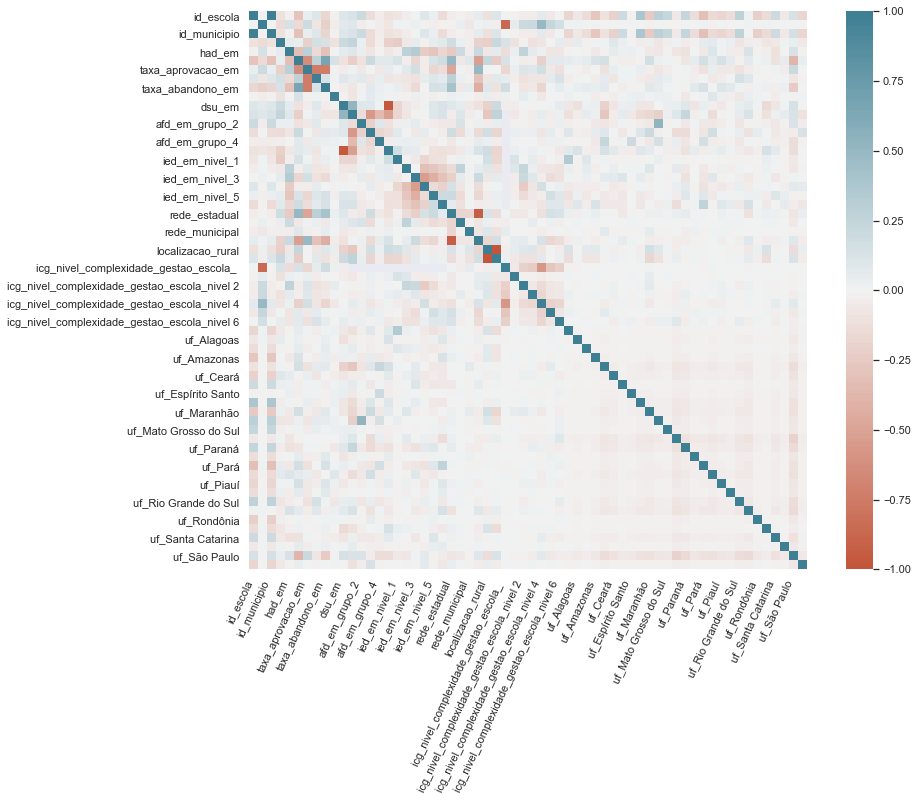

In [ ]:
corr = df_escola_em_dummies.corr()
sns.set(rc={'figure.figsize':(13.7,10.27)})

ax = sns.heatmap(   corr, 
                    vmin=-1, vmax=1, center=0, 
                    cmap=sns.diverging_palette(20, 220, n=200), 
                    square=True
                )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=65,
    horizontalalignment='right'
);

## Matriz de Correlação com menos colunas

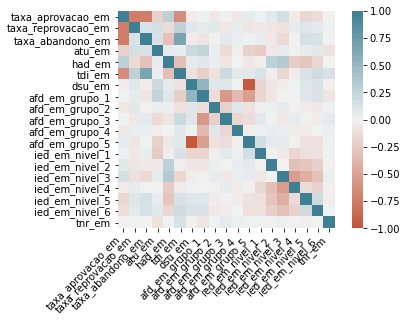

In [31]:
correlation_cols = ['taxa_aprovacao_em', 'taxa_reprovacao_em', 'taxa_abandono_em', 'ano',
                    'atu_em', 'had_em', 'tdi_em', 'dsu_em',  'afd_em_grupo_1',  'afd_em_grupo_2', 'afd_em_grupo_3','afd_em_grupo_4', 'afd_em_grupo_5', 
                    'ied_em_nivel_1', 'ied_em_nivel_2', 'ied_em_nivel_3', 'ied_em_nivel_4', 'ied_em_nivel_5', 'ied_em_nivel_6']
corr = df_escola_em[correlation_cols].corr()
ax = sns.heatmap(   
    corr, 
    vmin=-1, vmax=1, center=0, 
    cmap=sns.diverging_palette(20, 220, n=200), 
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Matriz de Correlação com as variáveis categóricas
Podemos notar algumas correlações importantes, como entre taxa de aprovação e rede da escola, taxa de aprovação sendo negativamente correlacionada com taxa de distorção de idade, que é positivamente correlacionado com reprovações e abandonos e também podemos observar que a quantidade de horas em sala de aula gera uma maior taxa de aprovação e uma menor taxa de abandono e reprovação. Além disso podemos notar que a localização da escola pouco influencia em grande parte dos índices.

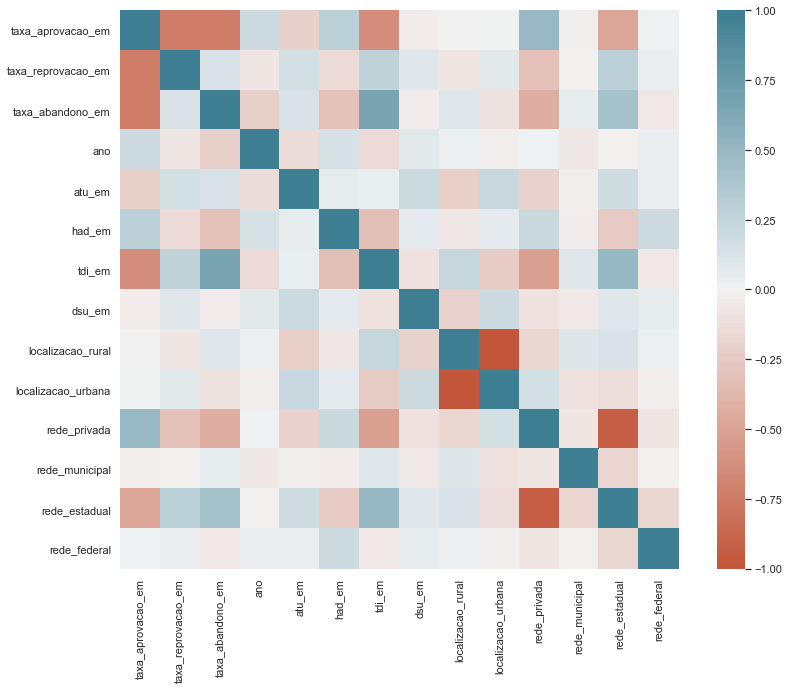

In [ ]:
correlation_cols = ['taxa_aprovacao_em', 'taxa_reprovacao_em', 'taxa_abandono_em', 'ano',
                    'atu_em', 'had_em', 'tdi_em', 'dsu_em', 'localizacao_rural', 'localizacao_urbana', 'rede_privada', 'rede_municipal', 'rede_estadual', 'rede_federal']
corr = df_escola_em_dummies[correlation_cols].corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True);

## Média de Aprovações por rede e localização:
podemos observar que a aprovação em média não difere tanto quanto à escola estar em área urbana ou rural, porém a aprovação média da rede privada chega a ser 10% a mais que das redes públicas.

        rede localizacao  taxa_aprovacao_em
0   estadual       rural          83.463038
1   estadual      urbana          79.100276
2    federal       rural          84.432125
3    federal      urbana          85.149513
4  municipal       rural          82.177937
5  municipal      urbana          80.731859
6    privada       rural          92.151295
7    privada      urbana          94.394280


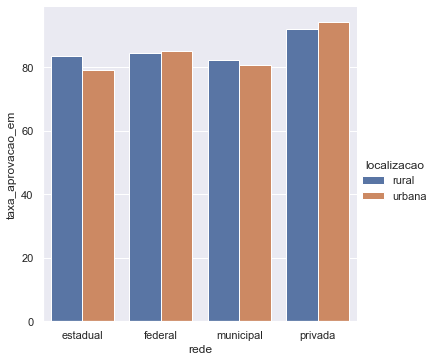

In [ ]:
media_aprovacao = df_escola_em[['taxa_aprovacao_em', 'rede', 'localizacao']].groupby(['rede', 'localizacao'], as_index=False).mean()
print(media_aprovacao)
sns.catplot(
    x = 'rede',
    y = 'taxa_aprovacao_em',
    hue = 'localizacao',
    kind = 'bar',
    data = media_aprovacao
);

## Média de reprovações por rede e localização
Já a média de reprovações é mais influenciada por localização e rede, tendo mais reprovações em áreas urbanas e uma taxa de reprovações mais alta na rede federal.

        rede localizacao  taxa_reprovacao_em
0   estadual       rural            7.190889
1   estadual      urbana           11.713641
2    federal       rural           11.698625
3    federal      urbana           12.036477
4  municipal       rural            6.403254
5  municipal      urbana            9.338435
6    privada       rural            3.575869
7    privada      urbana            5.039673


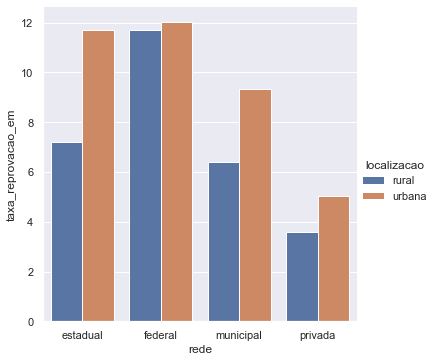

In [ ]:
media_reprovacao = df_escola_em[['taxa_reprovacao_em', 'rede', 'localizacao']].groupby(['rede', 'localizacao'], as_index=False).mean()
print(media_reprovacao)
sns.catplot(
    x = 'rede',
    y = 'taxa_reprovacao_em',
    hue = 'localizacao',
    kind = 'bar',
    data = media_reprovacao
);

## Média da taxa de abandono por rede e localização
É notável uma grande diferença entre rede rural e urbana, isso provavelmente devido à muitos estudantes no ensino médio precisarem trabalhar com a família na agricultura. Além disso, a rede privada tem uma taxa de abandono bem reduzida em áreas urbanas (menor que 1%) e a rede federal é dentre as públicas a que menos alunos abandonam a escola

        rede localizacao  taxa_abandono_em
0   estadual       rural          9.346073
1   estadual      urbana          9.186084
2    federal       rural          3.869250
3    federal      urbana          2.814011
4  municipal       rural         11.418809
5  municipal      urbana          9.929706
6    privada       rural          4.272836
7    privada      urbana          0.566047


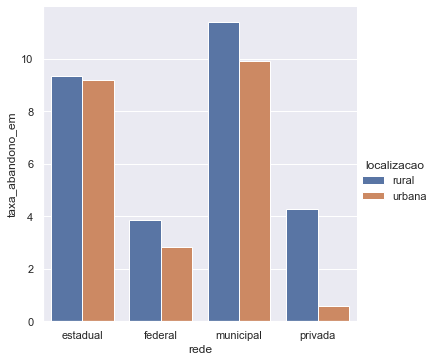

In [ ]:
media_abandono = df_escola_em[['taxa_abandono_em', 'rede', 'localizacao']].groupby(['rede', 'localizacao'], as_index=False).mean()
print(media_abandono)
sns.catplot(
    x = 'rede',
    y = 'taxa_abandono_em',
    hue = 'localizacao',
    kind = 'bar',
    data = media_abandono
);

## Média de abandono ao longo do tempo
Analisando a média de abandono ao longo do tempo, podemos ver que, num geral, ela teve uma queda considerável nos últimos anos, principalmente nas redes municipal e estadual.

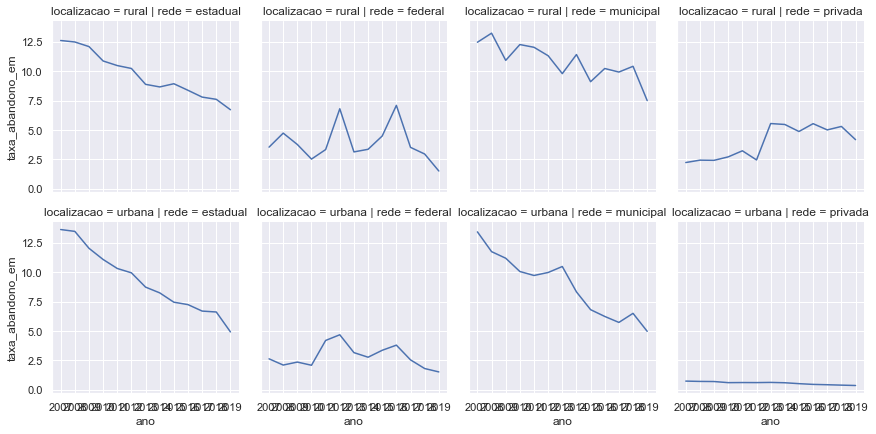

In [ ]:
media_abandono = df_escola_em[['taxa_abandono_em', 'rede', 'localizacao', 'ano']].groupby(['ano', 'rede', 'localizacao'], as_index=False).mean()
media_abandono["ano"] = media_abandono["ano"].astype('str')
sns.relplot(x=media_abandono['ano'], y=media_abandono["taxa_abandono_em"],
            col=media_abandono["rede"], row=media_abandono["localizacao"], height=3,
            estimator=None, data=media_abandono, kind = "line");

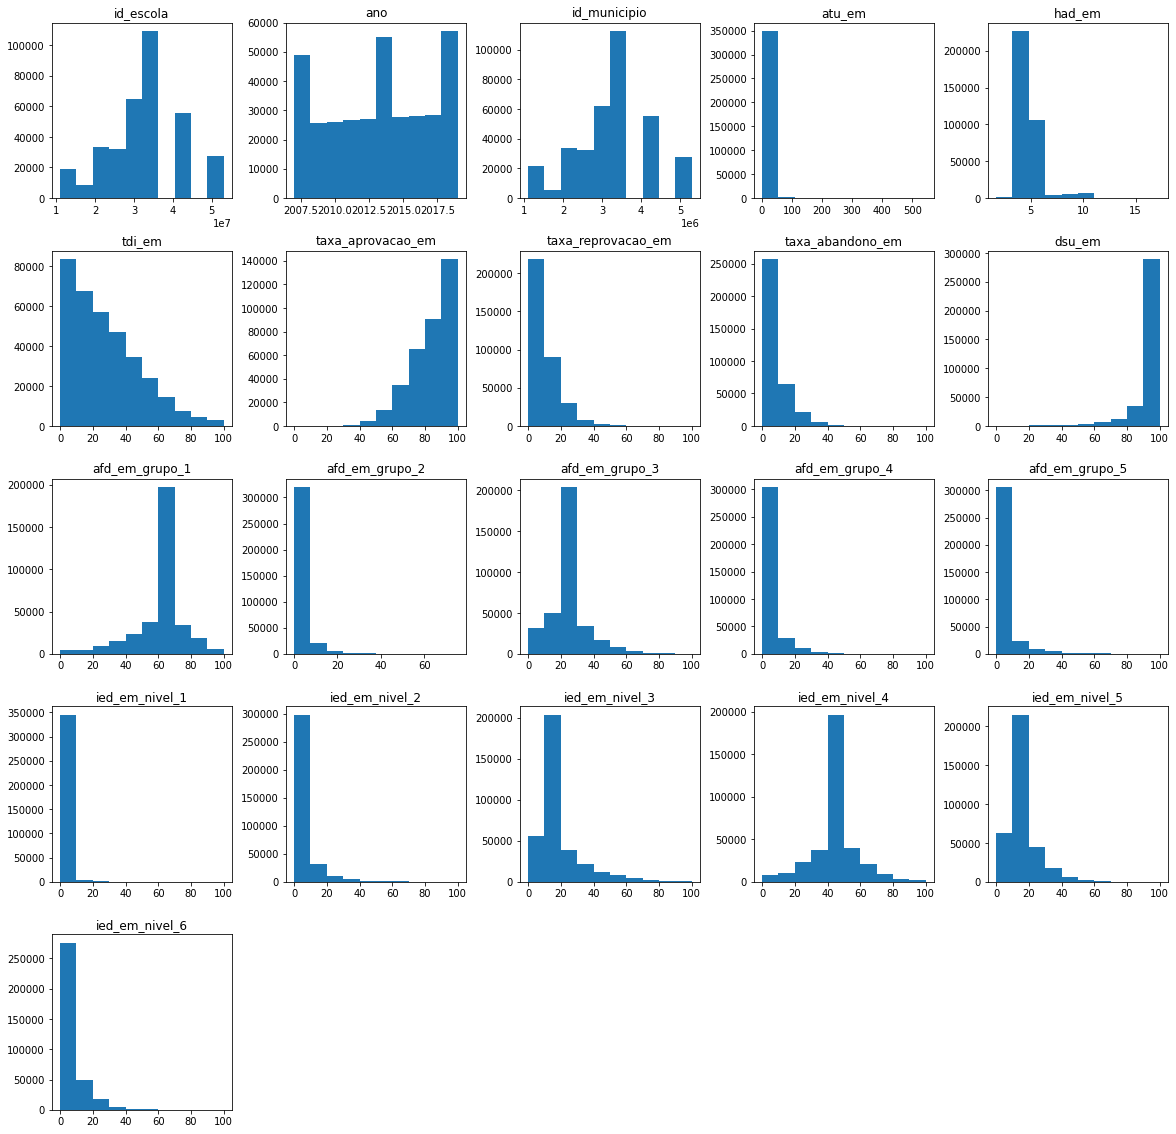

In [104]:
df_escola_em.hist(bins = 10, figsize=(20, 20), grid=False, sharex = False, sharey=False);

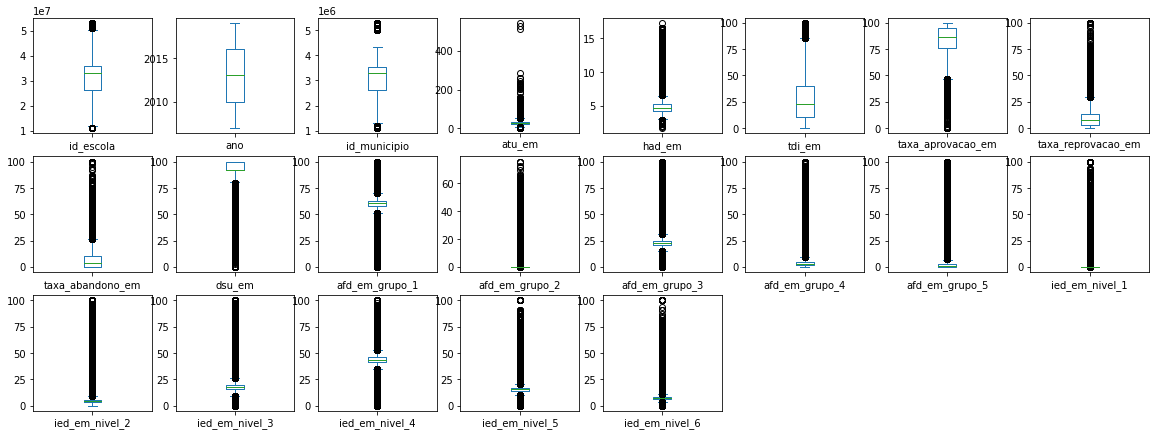

In [105]:
df_escola_em.plot(kind='box', subplots=True, layout=(8, 8), sharex=False, sharey=False, figsize=(20, 20));

## Verificar a qualidade dos dados
Os dados foram adquiridos do INEP, portanto não há preocupação quanto a veracidade dos mesmos pois são dados oficiais. Quanto a dados faltantes, há uma quantidade considerável de dados em branco referente às métricas `afd` e `ied`, que possuem apenas 196.331 das 350586 entradas.

Além disso, há uma pequena redução na quantidade de entradas das 3 taxas (aprovação, reprovação e abandono) do primeiro para o segundo ano (redução de 6703 entradas) e do segundo para o terceiro (redução de 7242 entradas), redução a qual atribuímos a fundação de novas escolas no período analisado, que, portanto, não teriam dados de aprovação em todos os anos do ensino médio. Por exemplo, institutos federais tem ingresso apenas no primeiro ano.

# IV. Modeling

+ Select modeling techniques: 
+ Generate test design: 
+ Build model: 
+ Assess model:  

In [ ]:
# modelos
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, RidgeCV, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

# seleção de modelos
from sklearn.model_selection import KFold, cross_val_score

# train test split
from sklearn.model_selection import train_test_split

# normalização
from sklearn.preprocessing import MinMaxScaler

seed = 0

In [ ]:
# substitui os dados NA por 0
df_escola_em_dummies = df_escola_em_dummies.fillna(0)

# separa em X e Y
X = df_escola_em_dummies.loc[:, df_escola_em_dummies.columns != "taxa_reprovacao_em"]
y = df_escola_em_dummies['taxa_reprovacao_em']

In [ ]:
# normaliza os dados
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [ ]:
# Splita entre treino e teste

trainX, testX, trainY, testY  = train_test_split(X, y, random_state = seed)
print(f"Train Size: {trainX.shape[0]}"), 
print(f"Test Size: {testX.shape[0]}")
print(f"Original Size: {df_escola_em.shape[0]}")

In [ ]:
models = []

models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(random_state=seed)))
models.append(('EN', ElasticNet(random_state=seed)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
# models.append(('SVR', SVR()))
models.append(('RIDGE', Ridge(random_state=seed)))
models.append(('RIDGECV', RidgeCV()))
models.append(('MLPR', MLPRegressor(random_state=seed)))
models.append(('GPR', GaussianProcessRegressor(random_state=seed)))

In [ ]:
results = []
names = []
num_folds = 10
score = 'r2'

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=score)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) 


In [ ]:
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = cross_val_score(SVR(), testX, testY, cv=kfold, scoring=score)

In [ ]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
"""kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = cross_val_score(LinearRegression(), trainX, trainY, cv=kfold, scoring=score)
msg = "%s: %f (%f)" % ('LR', cv_results.mean(), cv_results.std())
print(msg)"""

In [ ]:
"""model_LR = LinearRegression().fit(trainX, trainY)"""

## V. Evaluation                    

+ Evaluate results: 
+ Review process: 
+ Determine next steps: 

## VI. Deployment

+ Plan deployment: 
+ Plan monitoring and maintenance: 
+ Produce final report: 
+ Review project: 